<a href="https://colab.research.google.com/github/NdopnnoabasiJames/AI-ML-Activities/blob/main/Linear_regression_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""
Create a sample SQLite database with housing data for linear regression exercises.
"""
import os
import sqlite3
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Set random seed for reproducibility
np.random.seed(42)

def generate_housing_data(n_samples=1000):
    """Generate synthetic housing data."""
    # Generate features
    data = {
        'id': range(1, n_samples + 1),
        'price': np.random.normal(350000, 150000, n_samples).astype(int),
        'bedrooms': np.random.randint(1, 7, n_samples),
        'bathrooms': np.round(np.random.uniform(1, 4, n_samples), 1),
        'sqft_living': np.random.normal(2000, 800, n_samples).astype(int),
        'sqft_lot': np.random.normal(15000, 10000, n_samples).astype(int),
        'floors': np.random.choice([1, 1.5, 2, 2.5, 3], n_samples, p=[0.2, 0.3, 0.3, 0.15, 0.05]),
        'waterfront': np.random.choice([0, 1], n_samples, p=[0.95, 0.05]),
        'view': np.random.randint(0, 5, n_samples),
        'condition': np.random.randint(1, 6, n_samples),
        'grade': np.random.normal(7, 1, n_samples).round().clip(1, 13).astype(int),
        'sqft_above': 0,
        'sqft_basement': 0,
        'yr_built': np.random.randint(1900, 2023, n_samples),
        'yr_renovated': 0,
        'zipcode': np.random.choice([98001, 98002, 98003, 98004, 98005, 98006], n_samples),
        'lat': np.random.normal(47.5, 0.2, n_samples).round(6),
        'long': np.random.normal(-122.2, 0.2, n_samples).round(6),
        'sqft_living15': 0,
        'sqft_lot15': 0,
        'date': [(datetime(2023, 1, 1) + timedelta(days=np.random.randint(0, 365))).strftime('%Y%m%dT000000')
                for _ in range(n_samples)]
    }

    # Calculate derived features
    data['sqft_above'] = (data['sqft_living'] * np.random.uniform(0.7, 1.0, n_samples)).astype(int)
    data['sqft_basement'] = data['sqft_living'] - data['sqft_above']
    data['sqft_living15'] = (data['sqft_living'] * np.random.uniform(0.8, 1.2, n_samples)).astype(int)
    data['sqft_lot15'] = (data['sqft_lot'] * np.random.uniform(0.8, 1.2, n_samples)).astype(int)

    # Some houses have been renovated
    renovated = np.random.choice([0, 1], n_samples, p=[0.7, 0.3])
    data['yr_renovated'] = np.where(
        renovated == 1,
        (data['yr_built'] + np.random.randint(1, 50, n_samples)).clip(max=2022),
        0
    )

    # Create DataFrame
    df = pd.DataFrame(data)

    # Ensure no negative values
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols] = df[numeric_cols].clip(lower=0)

    return df

def create_database(df, db_path='datasets/housing.db'):
    """Create SQLite database and load data."""
    # Create the datasets directory if it doesn't exist
    os.makedirs(os.path.dirname(db_path), exist_ok=True)

    # Create a connection to the SQLite database
    conn = sqlite3.connect(db_path)

    # Write the data to a SQLite table
    df.to_sql('houses', conn, if_exists='replace', index=False)

    # Create additional tables for normalization
    # 1. Zipcode lookup table
    zipcodes = df[['zipcode', 'lat', 'long']].drop_duplicates()
    zipcodes.to_sql('zipcodes', conn, if_exists='replace', index=False)

    # 2. House features
    house_features = df[['id', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
                        'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement']]
    house_features.to_sql('house_features', conn, if_exists='replace', index=False)

    # 3. House transactions
    transactions = df[['id', 'price', 'date']]
    transactions.to_sql('transactions', conn, if_exists='replace', index=False)

    # Create indexes for better query performance
    with conn:
        conn.execute('CREATE INDEX idx_zipcode ON houses(zipcode)')
        conn.execute('CREATE INDEX idx_price ON houses(price)')
        conn.execute('CREATE INDEX idx_bedrooms ON houses(bedrooms)')
        conn.execute('CREATE INDEX idx_bathrooms ON houses(bathrooms)')

    # Close the connection
    conn.close()

    print(f"Database created successfully at {db_path}")
    print(f"Total records: {len(df)}")

def main():
    # Generate sample data
    print("Generating housing data...")
    housing_data = generate_housing_data(n_samples=2000)

    # Create database
    print("Creating SQLite database...")
    create_database(housing_data)

    # Save as CSV for reference
    csv_path = 'datasets/housing_data_extended.csv'
    os.makedirs(os.path.dirname(csv_path), exist_ok=True)
    housing_data.to_csv(csv_path, index=False)
    print(f"Sample data saved to {csv_path}")

    # Print sample queries
    print("\nSample SQL Queries:")
    print("""
-- Get average price by number of bedrooms
SELECT bedrooms, AVG(price) as avg_price, COUNT(*) as count
FROM houses
GROUP BY bedrooms
ORDER BY bedrooms;

-- Get price distribution by zipcode
SELECT zipcode,
       COUNT(*) as num_houses,
       MIN(price) as min_price,
       AVG(price) as avg_price,
       MAX(price) as max_price
FROM houses
GROUP BY zipcode
ORDER BY avg_price DESC;

-- Find houses with best value (low price per sqft)
SELECT id, price, sqft_living,
       ROUND(price*1.0/sqft_living, 2) as price_per_sqft,
       bedrooms, bathrooms
FROM houses
WHERE price > 0 AND sqft_living > 0
ORDER BY price_per_sqft ASC
LIMIT 10;
    """)

if __name__ == "__main__":
    main()

Generating housing data...
Creating SQLite database...
Database created successfully at datasets/housing.db
Total records: 2000
Sample data saved to datasets/housing_data_extended.csv

Sample SQL Queries:

-- Get average price by number of bedrooms
SELECT bedrooms, AVG(price) as avg_price, COUNT(*) as count
FROM houses
GROUP BY bedrooms
ORDER BY bedrooms;

-- Get price distribution by zipcode
SELECT zipcode,
       COUNT(*) as num_houses,
       MIN(price) as min_price,
       AVG(price) as avg_price,
       MAX(price) as max_price
FROM houses
GROUP BY zipcode
ORDER BY avg_price DESC;

-- Find houses with best value (low price per sqft)
SELECT id, price, sqft_living,
       ROUND(price*1.0/sqft_living, 2) as price_per_sqft,
       bedrooms, bathrooms
FROM houses
WHERE price > 0 AND sqft_living > 0
ORDER BY price_per_sqft ASC
LIMIT 10;
    


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
"""
Sample Data Generation for Linear Regression Exercises
"""
import numpy as np
import pandas as pd
import os

def generate_linear_data(n_samples=100, noise=1.0, random_state=42):
    """Generate linear data with noise."""
    np.random.seed(random_state)
    X = 2 * np.random.rand(n_samples, 1)
    y = 4 + 3 * X + np.random.randn(n_samples, 1) * noise
    return X, y

def generate_housing_data(n_samples=1000, random_state=42):
    """Generate synthetic housing price data."""
    np.random.seed(random_state)

    # Generate features
    size = 800 + 2500 * np.random.rand(n_samples)  # House size in sq ft
    bedrooms = np.random.randint(1, 6, n_samples)  # Number of bedrooms
    age = np.random.randint(0, 50, n_samples)      # House age in years

    # Generate target (price in $1000s)
    price = (
        50 * size / 1000 +  # Base price per sq ft
        20 * bedrooms ** 2 +  # Extra for more bedrooms
        -0.5 * age ** 1.5 +  # Depreciation with age
        np.random.randn(n_samples) * 50  # Random noise
    )

    # Create DataFrame
    data = pd.DataFrame({
        'size_sqft': size,
        'bedrooms': bedrooms,
        'age_years': age,
        'price_1000s': price
    })

    return data

def generate_polynomial_data(n_samples=100, noise=0.5, degree=2, random_state=42):
    """Generate polynomial data with noise."""
    np.random.seed(random_state)
    X = 6 * np.random.rand(n_samples, 1) - 3  # X between -3 and 3
    y = 0.5 * X**2 + X + 2 + np.random.randn(n_samples, 1) * noise
    return X, y

def save_sample_data():
    """Generate and save sample data files."""
    # Create data directory if it doesn't exist
    data_dir = 'datasets' # Directly create in the current directory
    os.makedirs(data_dir, exist_ok=True)

    # Generate and save linear data
    X_linear, y_linear = generate_linear_data(n_samples=200, noise=0.5)
    linear_data = np.hstack((X_linear, y_linear))
    np.savetxt(os.path.join(data_dir, 'linear_data.csv'),
              linear_data,
              delimiter=',',
              header='feature,target',
              comments='',
              fmt='%.4f')

    # Generate and save housing data
    housing_data = generate_housing_data(n_samples=500)
    housing_data.to_csv(os.path.join(data_dir, 'housing_data.csv'), index=False)

    # Generate and save polynomial data
    X_poly, y_poly = generate_polynomial_data(n_samples=100, noise=1.0, degree=2)
    poly_data = np.hstack((X_poly, y_poly))
    np.savetxt(os.path.join(data_dir, 'polynomial_data.csv'),
              poly_data,
              delimiter=',',
              header='feature,target',
              comments='',
              fmt='%.4f')

    print(f"Sample data saved to {data_dir}/")

if __name__ == "__main__":
    save_sample_data()

Sample data saved to datasets/


In [ ]:
# Step 1: Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
# Step 2: Generate Synthetic Data
np.random.seed(42)

# Independent variable (e.g., house size in 1000 sq ft)
X = 2 * np.random.rand(100, 1)

# Dependent variable (e.g., house price in $100,000)
y = 4 + 3 * X + np.random.randn(100, 1)

# Convert to DataFrame for better readability
data = pd.DataFrame(np.hstack((X, y)), columns=['Size (x1000 sqft)', 'Price ($1000s)'])
print(data.head())

   Size (x1000 sqft)  Price ($1000s)
0           0.749080        6.334288
1           1.901429        9.405278
2           1.463988        8.483724
3           1.197317        5.604382
4           0.312037        4.716440


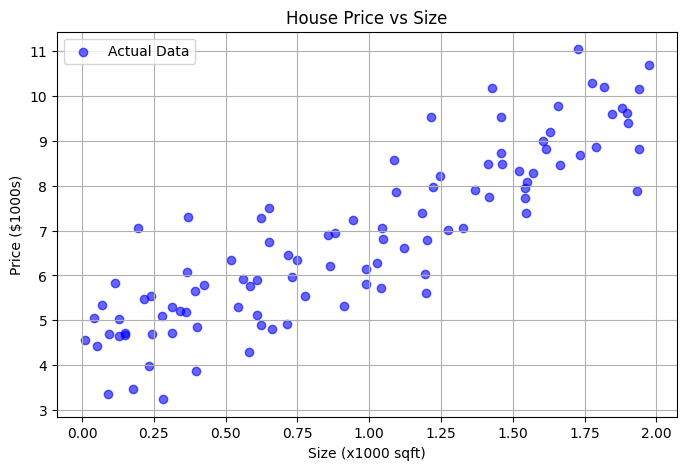

In [ ]:
# Step 3: Visualize Data
plt.figure(figsize=(8, 5))
plt.scatter(X, y, color='blue', alpha=0.6, label='Actual Data')
plt.title("House Price vs Size")
plt.xlabel("Size (x1000 sqft)")
plt.ylabel("Price ($1000s)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Step 4: Implement Linear Regression from Scratch

# Add a column of ones for the intercept term
X_b = np.c_[np.ones((100, 1)), X]

# Compute coefficients using the Normal Equation
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

print("Intercept (β₀):", theta_best[0][0])
print("Slope (β₁):", theta_best[1][0])

Intercept (β₀): 4.21509615754675
Slope (β₁): 2.7701133864384806


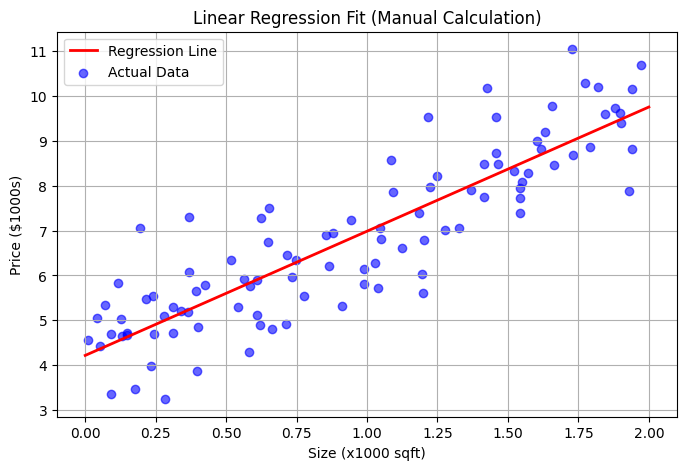

In [ ]:
# Step 5: Predict using our manual model
X_new = np.array([[0], [2]])  # new house sizes
X_new_b = np.c_[np.ones((2, 1)), X_new]
y_pred = X_new_b.dot(theta_best)

# Visualize
plt.figure(figsize=(8, 5))
plt.plot(X_new, y_pred, color='red', linewidth=2, label="Regression Line")
plt.scatter(X, y, color='blue', alpha=0.6, label="Actual Data")
plt.title("Linear Regression Fit (Manual Calculation)")
plt.xlabel("Size (x1000 sqft)")
plt.ylabel("Price ($1000s)")
plt.legend()
plt.grid(True)
plt.show()

Intercept (β₀): 4.215096157546747
Slope (β₁): 2.7701133864384837


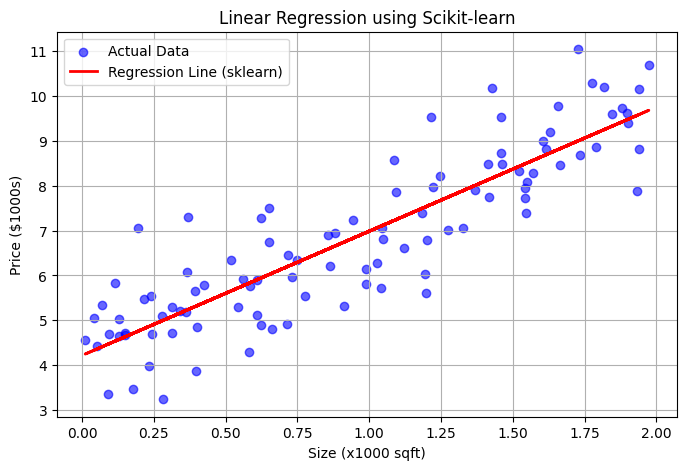

In [ ]:
# Step 6: Implement Linear Regression using Scikit-learn

model = LinearRegression()
model.fit(X, y)

print("Intercept (β₀):", model.intercept_[0])
print("Slope (β₁):", model.coef_[0][0])

# Predictions
y_pred_sklearn = model.predict(X)

# Visualize the fitted line
plt.figure(figsize=(8, 5))
plt.scatter(X, y, color='blue', alpha=0.6, label='Actual Data')
plt.plot(X, y_pred_sklearn, color='red', linewidth=2, label='Regression Line (sklearn)')
plt.title("Linear Regression using Scikit-learn")
plt.xlabel("Size (x1000 sqft)")
plt.ylabel("Price ($1000s)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Step 7: Evaluate Model
mse = mean_squared_error(y, y_pred_sklearn)
rmse = np.sqrt(mse)
r2 = r2_score(y, y_pred_sklearn)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Squared Error (MSE): 0.8066
Root Mean Squared Error (RMSE): 0.8981
R² Score: 0.7693


In [8]:
# Step 1: Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [9]:
# Step 2: Load the generated dataset
data_path = 'datasets/housing_data.csv'
df = pd.read_csv(data_path)

# Preview data
print("Shape of dataset:", df.shape)
print(df.head())

Shape of dataset: (500, 4)
     size_sqft  bedrooms  age_years  price_1000s
0  1736.350297         1         10   183.337976
1  3176.785766         1         41    -5.928997
2  2629.984855         1          1    74.722984
3  2296.646210         5          2   578.822693
4  1190.046601         4         22   325.628456


         size_sqft    bedrooms   age_years  price_1000s
count   500.000000  500.000000  500.000000   500.000000
mean   2046.404281    2.958000   25.410000   250.771203
std     746.721021    1.440968   14.027096   196.396531
min     812.653960    1.000000    0.000000  -159.093012
25%    1403.199227    2.000000   13.000000    94.790827
50%    2082.909371    3.000000   26.000000   220.053763
75%    2690.312204    4.000000   38.000000   399.394740
max    3282.411990    5.000000   49.000000   718.811179


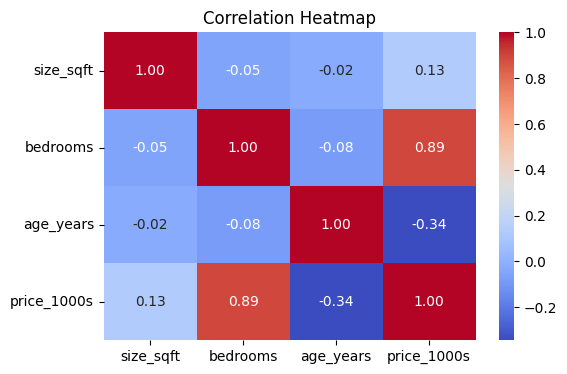

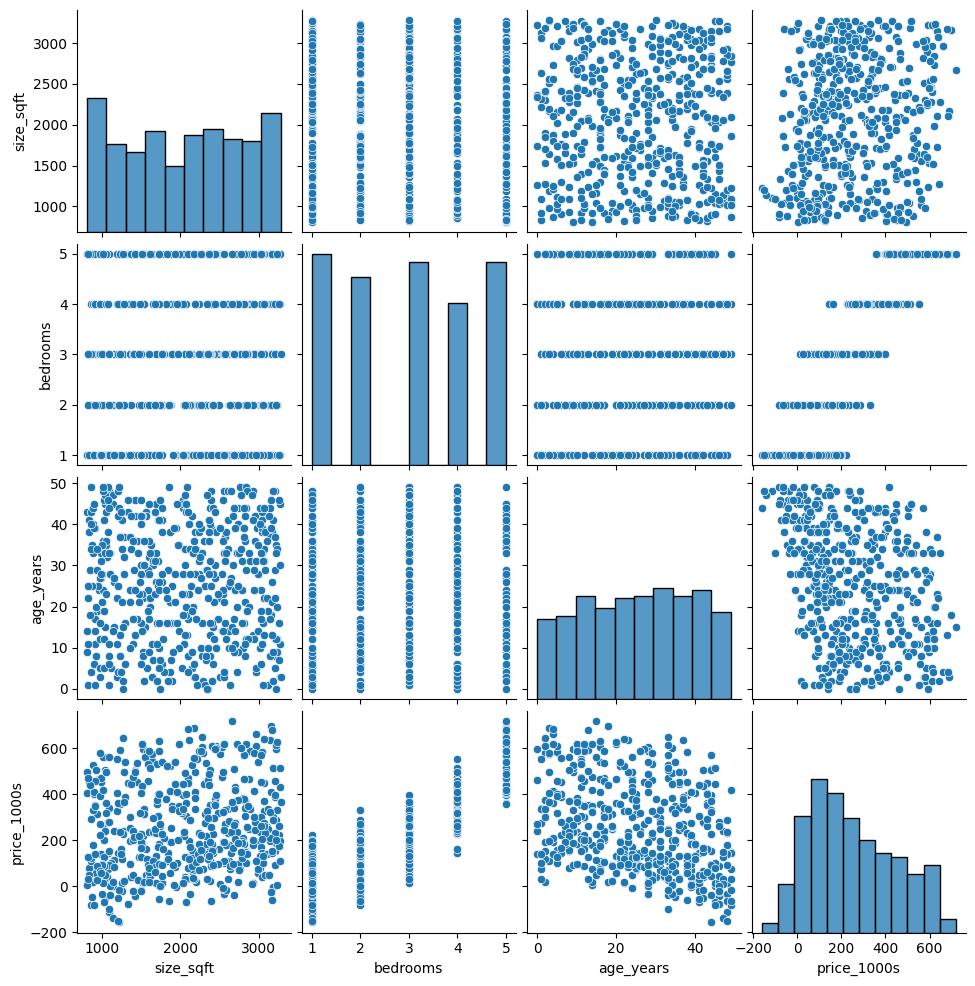

In [10]:
# Step 3: Basic statistics
print(df.describe())

# Correlation matrix
plt.figure(figsize=(6, 4))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# Pairplot
sns.pairplot(df)
plt.show()

In [11]:
# Step 4: Define features (X) and target (y)
X = df[['size_sqft', 'bedrooms', 'age_years']]
y = df['price_1000s']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])

Training samples: 400
Testing samples: 100


In [12]:
# Step 5: Train Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Coefficients
print("Intercept (β₀):", model.intercept_)
print("Coefficients (β₁, β₂, β₃):", model.coef_)

Intercept (β₀): -105.87902011463262
Coefficients (β₁, β₂, β₃): [ 4.55155346e-02  1.21126663e+02 -3.72132575e+00]


In [13]:
# Step 6: Predict on test set
y_pred = model.predict(X_test)

# Compare actual vs predicted
comparison = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred
}).head(10)

print(comparison)

       Actual   Predicted
0  154.073415  238.543100
1  151.806896  222.965470
2  268.274913  322.664737
3   48.793579  -10.108560
4  448.146645  391.785916
5  296.891254  338.458599
6  122.902523  147.708452
7  445.980653  435.578123
8  138.296590   58.466014
9  376.377287  410.437558


In [14]:
# Step 7: Model evaluation
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.3f}")

Mean Squared Error (MSE): 3139.05
Root Mean Squared Error (RMSE): 56.03
R² Score: 0.907


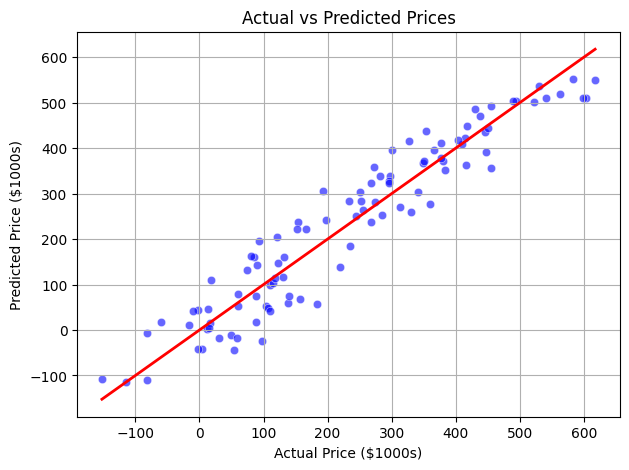

In [26]:
# Step 8: Visualize Actual vs Predicted
plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_test, y=y_pred, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         color='red', linewidth=2)
plt.title("Actual vs Predicted Prices")
plt.xlabel("Actual Price ($1000s)")
plt.ylabel("Predicted Price ($1000s)")
plt.grid(True)
plt.show()

In [2]:
# Step 1: Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
# Step 2: Load dataset
data_path = 'datasets/housing_data.csv'
df = pd.read_csv(data_path)

print("Dataset shape:", df.shape)
print(df.head())

# Define features and target
X = df[['size_sqft', 'bedrooms', 'age_years']]
y = df['price_1000s']

# Split into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Dataset shape: (500, 4)
     size_sqft  bedrooms  age_years  price_1000s
0  1736.350297         1         10   183.337976
1  3176.785766         1         41    -5.928997
2  2629.984855         1          1    74.722984
3  2296.646210         5          2   578.822693
4  1190.046601         4         22   325.628456


In [4]:
# Step 3: Create polynomial features (degree=2)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

print("Original feature shape:", X_train.shape)
print("Transformed feature shape:", X_train_poly.shape)

# Get feature names for reference
print("Polynomial feature names:")
print(poly.get_feature_names_out(X.columns))

Original feature shape: (400, 3)
Transformed feature shape: (400, 9)
Polynomial feature names:
['size_sqft' 'bedrooms' 'age_years' 'size_sqft^2' 'size_sqft bedrooms'
 'size_sqft age_years' 'bedrooms^2' 'bedrooms age_years' 'age_years^2']


In [5]:
# Step 4: Standardize features
scaler = StandardScaler()
X_train_poly_scaled = scaler.fit_transform(X_train_poly)
X_test_poly_scaled = scaler.transform(X_test_poly)

In [6]:
# Step 5: Train model
poly_model = LinearRegression()
poly_model.fit(X_train_poly_scaled, y_train)

# Coefficients and intercept
print("Intercept (β₀):", poly_model.intercept_)
print("Number of Coefficients:", len(poly_model.coef_))

Intercept (β₀): 255.75169814594827
Number of Coefficients: 9


In [7]:
# Step 6: Predict
y_pred_poly = poly_model.predict(X_test_poly_scaled)

# Evaluate
mse_poly = mean_squared_error(y_test, y_pred_poly)
rmse_poly = np.sqrt(mse_poly)
r2_poly = r2_score(y_test, y_pred_poly)

print(f"Polynomial Regression - RMSE: {rmse_poly:.2f}")
print(f"Polynomial Regression - R² Score: {r2_poly:.3f}")

Polynomial Regression - RMSE: 49.60
Polynomial Regression - R² Score: 0.927


In [8]:
# Step 7: Baseline Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)

# Evaluate linear model
mse_linear = mean_squared_error(y_test, y_pred_linear)
rmse_linear = np.sqrt(mse_linear)
r2_linear = r2_score(y_test, y_pred_linear)

print(f"Linear Regression - RMSE: {rmse_linear:.2f}")
print(f"Linear Regression - R² Score: {r2_linear:.3f}")

Linear Regression - RMSE: 56.03
Linear Regression - R² Score: 0.907


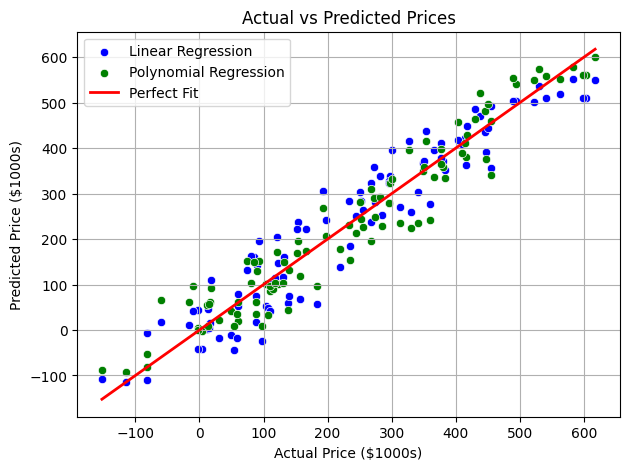

In [9]:
# Step 8: Visualization of Predictions
plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_test, y=y_pred_linear, color='blue', label='Linear Regression')
sns.scatterplot(x=y_test, y=y_pred_poly, color='green', label='Polynomial Regression')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         color='red', linewidth=2, label='Perfect Fit')
plt.title("Actual vs Predicted Prices")
plt.xlabel("Actual Price ($1000s)")
plt.ylabel("Predicted Price ($1000s)")
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# Step 9: Save predictions
results = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted_Linear': y_pred_linear,
    'Predicted_Poly': y_pred_poly
})
results.to_csv('datasets/model_predictions_comparison.csv', index=False)
print("Results saved to datasets/model_predictions_comparison.csv")

Results saved to datasets/model_predictions_comparison.csv
